# Perform forward kinematics with a trajectory

In this notebook, we are going to generate a short video for a random robot movement you can watch in your browser.

First of all, we need some modules. You can create some simple modules built from geometric primitives yourself - there is a distinct tutorial to that purpose. If you don't want to, we can use the set of simple modules provided with the timor source code:

In [22]:
from pathlib import Path

# provide your own filepaths if you already did the module generation tutorial:
your_modules_json = Path('')
your_assets_directory = Path('')

if your_modules_json == Path(''):
    from timor.utilities.file_locations import get_module_db_files
    modules_file = get_module_db_files('geometric_primitive_modules')

In [23]:
import numpy as np
import timor
from timor.Module import *
from timor.utilities.visualization import animation, MeshcatVisualizerWithAnimation
from numpy import pi

#create the DB object
db = ModulesDB.from_json_file(modules_file)

#print out available modules in DB
print(db.by_name)
print(db.by_id)
# print(db.all_joints)
# print(db.all_connectors)


{'Revolute Joint': <timor.Module.AtomicModule object at 0x7f8b713a8640>, 'Prismatic Joint': <timor.Module.AtomicModule object at 0x7f8b713a9510>, 'I shaped link 0.08-0.08-45': <timor.Module.AtomicModule object at 0x7f8b7151a7a0>, 'Base': <timor.Module.AtomicModule object at 0x7f8b715188e0>, 'L shaped link 0.1-0.08-15': <timor.Module.AtomicModule object at 0x7f8b7151a5f0>, 'L shaped link 0.1-0.08-30': <timor.Module.AtomicModule object at 0x7f8b71542140>, 'L shaped link 0.1-0.08-45': <timor.Module.AtomicModule object at 0x7f8b71541000>, 'Demo EEF': <timor.Module.AtomicModule object at 0x7f8b7151bf10>, 'I shaped link 0.08-0.08-15': <timor.Module.AtomicModule object at 0x7f8b71519240>, 'I shaped link 0.08-0.08-30': <timor.Module.AtomicModule object at 0x7f8b71519ea0>}
{'J2': <timor.Module.AtomicModule object at 0x7f8b713a8640>, 'J1': <timor.Module.AtomicModule object at 0x7f8b713a9510>, 'i_45': <timor.Module.AtomicModule object at 0x7f8b7151a7a0>, 'base': <timor.Module.AtomicModule object 

In [24]:
#contains IDs we care about. The order is arbitrary, but if we want to make a robot out of this (i.e. kinematic tree) we should put in order.
modules = ('base', 'J2', 'i_45', 'J2', 'J2', 'eef')
A = ModuleAssembly.from_serial_modules(db, modules)
robot = A.to_pin_robot() #convert to pinocchio robot
# db = ModulesDB.from_name('IMPROV')
# # Create assembly and set configuration
# A = ModuleAssembly.from_serial_modules(db, ['1', '21', '4', '21', '15', '22', '5', '23', '12'])
# A.robot.update_configuration(np.array((0, pi / 7, -2 * pi / 7, 0, -pi / 7, 0, pi / 10, 0)))
# robot = A.to_pin_robot()

viz = robot.visualize()
viz.viewer.jupyter_cell(height=400) # generate a jupyter cell to visualize the robot

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [25]:
def specific_pose_valid(robot, theta: List[float], task = None) -> bool:
	#perform FK on the theta list
	robot.fk(theta, visual = True, collision = True)
	
	self_collisions = robot.has_self_collision()
	collisions = False if task is None else robot.has_collisions(task, safety_margin=0) #may need to alter safety margin

	return not (collisions or self_collisions)

In [26]:
"""Example of manually defined trajectory with Forwards Kinematics (pt 1)"""

modules = ('base', 'i_30', 'J2', 'J2', 'J2', 'i_30', 'eef')
B = ModuleAssembly.from_serial_modules(db, modules)
long_robot = B.to_pin_robot() #convert to pinocchio robot

q_0 = [np.pi, np.pi, np.pi] #start in this config with no collisions

no_collision_eff = long_robot.fk(q_0, collision = True, visual = True)

#the collisions() method exists, but requires the definition of a task. we look at collision pairs as a quick shortcut.
print("Self collision in this state: ", long_robot.has_self_collision())
long_robot.visualize_self_collisions() #nothing is highlighted b/c no self collisions

print("Specific pose valid: ", specific_pose_valid(long_robot, q_0))

q_1 = [0,0,0]
collision_eff = long_robot.fk(q_1, collision = True, visual = True)

#the collisions() method exists, but requires the definition of a task. we look at collision pairs as a quick shortcut.
print("Self collision in this state: ", long_robot.has_self_collision())
long_robot.visualize_self_collisions() #nothing is highlighted b/c no self collisions

print("Specific pose valid: ", specific_pose_valid(long_robot, q_1))

Self collision in this state:  False
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/
Specific pose valid:  True
Self collision in this state:  True
collision pair detected: 1 , 11 - collision: Yes
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
Specific pose valid:  False


In [27]:
from timor.utilities.transformation import Transformation
from timor.utilities.tolerated_pose import ToleratedPose
from timor.utilities.dtypes import IKMeta

no_collision_t = Transformation(no_collision_eff)
no_collision_pose = ToleratedPose(no_collision_t)

In [28]:
def inverse_kinematics(robot, eff_pose, task, dof):
    transformation = Transformation(eff_pose)
    tolerated_pose = ToleratedPose(transformation)
    info = IKMeta(dof=dof, max_iter=100000, task=task)
    #return robot.ik(eef_pose=tolerated_pose, task=task)
    return robot.ik_scipy(eef_pose=tolerated_pose, info=info)

In [29]:
#print(long_robot.ik(no_collision_pose))
# print(inverse_kinematics(long_robot, no_collision_eff))
# print(inverse_kinematics(long_robot, collision_eff))
#print(long_robot.ik(collision_eff))

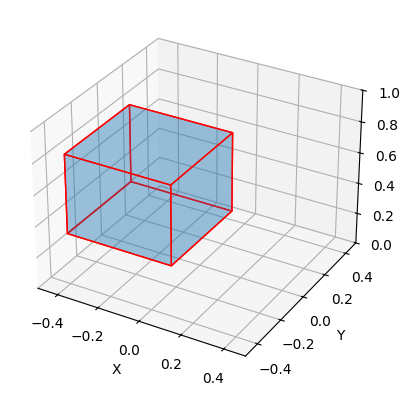

1


In [30]:
import datetime
import time
import sys
import os
import numpy as np
from timor.Geometry import Box, ComposedGeometry, Cylinder
from timor.task.Obstacle import Obstacle
from timor.task.Task import Task, TaskHeader
from timor.utilities.transformation import Transformation
from timor.utilities.spatial import rotX, rotY, rotZ

project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(project_root)

from random_env_generation.random_env_generation import plot_random_cuboids, plot_random_cuboids_with_reachability, plot_reachability_interactive

cuboid_data_list = plot_random_cuboids(num_cuboids=1, total_volume=0.2, space_size=(1.0, 1.0, 1.0))

header = TaskHeader(
    ID='Random Obstacles Generation',
    tags=['Capstone', 'demo'],
    date=datetime.datetime(2024, 10, 28),
    author=['Jonas Li'],
    email=['liyunzhe.jonas@berkeley.edu'],
    affiliation=['UC Berkeley']
)

box = []
for idx, info in enumerate(cuboid_data_list):
    size, displacement = info["size"], info["origin"]
    box.append(Obstacle(ID=str(idx), 
                collision=Box(
                    dict(x=size['x'], y=size['y'], z=size['z']),  # Size
                    pose=Transformation.from_translation([displacement['x'], displacement['y'], displacement['z']])
                        @ Transformation.from_rotation(rotY(2*np.pi)[:3, :3]))))# Displacement
print(len(box))
task = Task(header, obstacles=[i for i in box])

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R

def check_reachable_cubes(robot, space_dimensions, segment_len, error, task=None):
    # Extract the x, y, z dimensions of the main cube
    x_dim, y_dim, z_dim = space_dimensions

    # Initialize lists to store the coordinates of reachable and unreachable centers
    reachable_points = []
    unreachable_points = []
    reachable_config = []

    # Generate the ranges for each axis with 0.1m increments
    x_range = np.arange(-x_dim / 2, x_dim / 2 + segment_len, segment_len)
    y_range = np.arange(-y_dim / 2, y_dim / 2 + segment_len, segment_len)
    z_range = np.arange(0, z_dim, segment_len)

    # rotations = R.random(n_rotations)
    
    # Iterate through each small cube's center
    total_iterations = len(x_range) * len(y_range) * len(z_range)
    with tqdm(total=total_iterations, desc="Overall Progress", position=0) as pbar:
        for x in x_range:
            for y in y_range:
                for z in z_range:
                    # Define a target 4x4 transformation matrix for the cube center
                    target_matrix = np.array([
                        [1,  0, 0, x],
                        [0, -1, 0, y],
                        [0, 0, -1, z],
                        [0,  0, 0, 1]
                    ])
                    
                    # Check reachability and store the center accordingly
                    pose, success = inverse_kinematics(robot, target_matrix, task=task, dof=3)
                    if success:
                        reachable_points.append([x, y, z])
                        reachable_config.append(pose)
                    else:
                        end_eff = robot.fk(pose, collision = True, visual = True)
                        target_point = np.array([x,y,z])
                        actual_point = np.array([end_eff[0][3], end_eff[1][3], end_eff[2][3]])
                        distance = np.linalg.norm(target_point - actual_point)
                        
                        if distance < error:
                            reachable_points.append([x, y, z])
                            reachable_config.append(pose)
                        else:
                            unreachable_points.append([x, y, z])
                    pbar.update(1)

                    # progress += 1
                    # print("Progress: ", progress/(len(x_range) * len(y_range) * len(z_range)))

    return reachable_points, unreachable_points, reachable_config

def plot_reachability(reachable_points, unreachable_points):
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert lists to numpy arrays for easier plotting
    reachable_points = np.array(reachable_points)
    unreachable_points = np.array(unreachable_points)

    # Plot reachable points in green
    if len(reachable_points) > 0:
        ax.scatter(reachable_points[:, 0], reachable_points[:, 1], reachable_points[:, 2], color='green', label='Reachable', s=5)

    # Plot unreachable points in red
    if len(unreachable_points) > 0:
        ax.scatter(unreachable_points[:, 0], unreachable_points[:, 1], unreachable_points[:, 2], color='red', label='Unreachable', s=5)

    # Set plot labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Reachability Plot')
    ax.legend()

    plt.show()

In [32]:
space_dimensions = [1.0, 1.0, 1.0]
reachable_points, unreachable_points, reachable_configs = check_reachable_cubes(long_robot, space_dimensions, 0.1, 0.01)

Overall Progress: 100%|██████████| 1210/1210 [00:16<00:00, 73.94it/s]


In [33]:
reachable_points_obstacles, unreachable_points_obstacles, reachable_configs_obstacles = check_reachable_cubes(long_robot, space_dimensions, 0.1, 0.01, task=task)

Overall Progress:  84%|████████▍ | 1019/1210 [00:12<00:02, 75.16it/s]/home/mscsim/anaconda3/envs/timor-env2/lib/python3.10/site-packages/timor/Robot.py:48: RuntimeWarning:

invalid value encountered in arccos

Overall Progress: 100%|██████████| 1210/1210 [00:16<00:00, 73.47it/s]


In [34]:
print("Reachable space %: ", len(reachable_points_obstacles) / (len(reachable_points_obstacles) + len(unreachable_points_obstacles)))
#plot_reachability(reachable_points, unreachable_points)
plot_random_cuboids_with_reachability(cuboid_data_list, reachable_points=reachable_points_obstacles, unreachable_points=unreachable_points_obstacles)
plot_reachability_interactive(reachable_points=reachable_points, unreachable_points=unreachable_points)

Reachable space %:  0.015702479338842976


In [35]:
print("Reachable space % without obstacles: ", len(reachable_points) / (len(reachable_points) + len(unreachable_points)))
print("Reachable space % with obstacles: ", len(reachable_points_obstacles) / (len(reachable_points_obstacles) + len(unreachable_points_obstacles)))

print(reachable_points)
for i in range(len(reachable_configs)):
    end_eff = long_robot.fk(reachable_configs[i], collision = True, visual = True)
    print(end_eff)
    target_point = np.array(reachable_points[i])
    actual_point = np.array([end_eff[0][3], end_eff[1][3], end_eff[2][3]])
    print(actual_point)
    distance = np.linalg.norm(target_point - actual_point)
    print("Distance: ", distance)

Reachable space % without obstacles:  0.012396694214876033
Reachable space % with obstacles:  0.015702479338842976
[[-1.1102230246251565e-16, 0.09999999999999987, 0.6000000000000001], [0.09999999999999987, -0.4, 0.30000000000000004], [0.09999999999999987, -0.4, 0.4], [0.09999999999999987, -0.20000000000000007, 0.7000000000000001], [0.09999999999999987, 0.19999999999999984, 0.0], [0.09999999999999987, 0.19999999999999984, 0.7000000000000001], [0.09999999999999987, 0.3999999999999998, 0.30000000000000004], [0.19999999999999984, -0.20000000000000007, 0.8], [0.19999999999999984, 0.19999999999999984, 0.8], [0.2999999999999998, -0.4, 0.0], [0.2999999999999998, 0.2999999999999998, 0.8], [0.2999999999999998, 0.3999999999999998, 0.0], [0.3999999999999998, -0.5, 0.1], [0.3999999999999998, -0.5, 0.6000000000000001], [0.3999999999999998, 0.4999999999999998, 0.1]]
[[-0.258  0.565 -0.784 -0.007]
 [-0.565 -0.747 -0.352  0.101]
 [-0.784  0.352  0.512  0.601]
 [ 0.     0.     0.     1.   ]]
[-0.0069042

In [36]:
target_matrix = np.array([
                        [1, 0, 0, -0.8],
                        [0, 1, 0, 0.2],
                        [0, 0, 1, 0],
                        [0, 0, 0, 1]
                    ])
                    
                    # Check reachability and store the center accordingly
conf, success = inverse_kinematics(long_robot, target_matrix, task=task, dof=3)
print(conf, success)
print(long_robot.fk(conf, collision=True))

[ 0.86741868 -1.49263346 -0.86741551] False
[[ 0.373  0.532 -0.76  -0.067]
 [ 0.532  0.549  0.645  0.087]
 [ 0.76  -0.645 -0.078  0.312]
 [ 0.     0.     0.     1.   ]]
